In [18]:
import random

import joblib
import numpy as np
import sent2vec
import umap

from sklearn.metrics import precision_recall_fscore_support as score

from sentence_classification.preprocess import read_sentences_from_file, read_sentences_from_file_with_papid, \
    clean_sentences, clean_sentences_with_papid

In [2]:
model_path = "../../biosentvec/model.bin"
biosentvec_model = sent2vec.Sent2vecModel()
try:
    biosentvec_model.load_model(model_path)
except Exception as e:
    print(e)
print('model successfully loaded')

model successfully loaded


In [3]:
sent_expr_pattern = [line.strip() for line in open("../../extracted_sentences/sentences_exp_pattern.txt") if line.strip()]
sent_subcellloc = [line.strip() for line in open("../../extracted_sentences/sentences_exp_subcellloc.txt") if line.strip()]
neg_sent_otherexpr = [line.strip().split("\t")[1] for line in open("../../extracted_sentences/GROBID_neg_sentences_expr.txt") if line.strip()]

In [7]:
sent_expr_pattern_clean = [sent for sent in clean_sentences(sent_expr_pattern) if sent]
sent_subcellloc_clean = [sent for sent in clean_sentences(sent_subcellloc) if sent]
neg_sent_expr_clean = [sent for sent in clean_sentences(neg_sent_otherexpr) if sent]
positive_sent_expr_clean = [*sent_expr_pattern_clean, *sent_subcellloc_clean]

In [11]:
def get_random_sentence_subset(sentences, max_num_sentences):
    corpus = sentences
    random.shuffle(corpus)
    return corpus[0:max_num_sentences]

corpus_expr_positive = get_random_sentence_subset(positive_sent_expr_clean, 2400)
corpus_expr_negative = get_random_sentence_subset(neg_sent_expr_clean, 2400)
with open("../../sentence_embeddings/GROBID_corpus_db_expr_positive.txt", "w") as corpus_expr_file:
    for sent in corpus_expr_positive:
        corpus_expr_file.write(sent + "\n")
with open("../../sentence_embeddings/GROBID_corpus_db_expr_negative.txt", "w") as corpus_neg_otherexpr_file:
    for sent in corpus_expr_negative:
        corpus_neg_otherexpr_file.write(sent[1] + "\n")

In [12]:
corpus_embeddings_expr_positive = biosentvec_model.embed_sentences(corpus_expr_positive)
corpus_embeddings_expr_negative = biosentvec_model.embed_sentences(corpus_expr_negative)

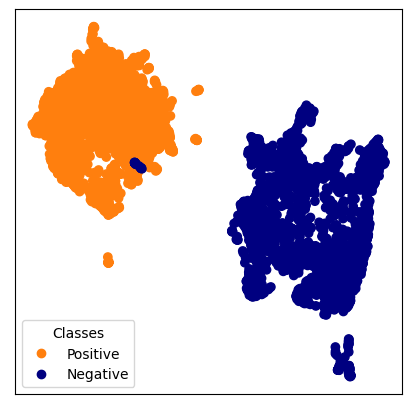

In [14]:
umap_reducer = umap.UMAP(metric='cosine')
corpus_embeddings_expr_positive_2d = umap_reducer.fit_transform(corpus_embeddings_expr_positive)
corpus_embeddings_expr_negative_2d = umap_reducer.fit_transform(corpus_embeddings_expr_negative)

colors = [0] * len(corpus_embeddings_expr_positive_2d) + [1] * len(corpus_embeddings_expr_negative_2d)

corpus_2d = np.vstack((corpus_embeddings_expr_positive_2d, corpus_embeddings_expr_negative_2d))
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

values = colors
colors2 = ListedColormap(['tab:orange','navy'])
classes = ['Positive', 'Negative']
fig, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(x=list(corpus_2d[:,0]), y=list(corpus_2d[:,1]), c=values, cmap=colors2)
plt.xticks([])
plt.yticks([])
legend = ax.legend(handles=scatter.legend_elements()[0], loc="lower left", title="Classes", labels=classes)

In [19]:
from random import shuffle
from sklearn.neural_network import MLPClassifier
import math

converted_corpus_expr = [*[(emb_val, 1) for emb_val in corpus_embeddings_expr_positive], *[(emb_val, 0) for emb_val in corpus_embeddings_expr_negative]]
indices_expr = [i for i in range(len(converted_corpus_expr))]
shuffle(indices_expr)
training_size_expr = math.ceil(len(converted_corpus_expr) * 0.8)
training_indices_expr = indices_expr[0:training_size_expr]
test_indices_expr = indices_expr[training_size_expr:]
training_set_data_expr = [converted_corpus_expr[index][0] for index in training_indices_expr]
training_set_classes_expr = [converted_corpus_expr[index][1] for index in training_indices_expr]
test_set_data_expr = [converted_corpus_expr[index][0] for index in test_indices_expr]
test_set_classes_expr = [converted_corpus_expr[index][1] for index in test_indices_expr]
base_clf = MLPClassifier(hidden_layer_sizes=(10, 10), alpha=0.1)
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)

test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.99103139 0.9922179 ]
recall: [0.99103139 0.9922179 ]
fscore: [0.99103139 0.9922179 ]
support: [446 514]


In [20]:
clf_all = base_clf.fit([emb_class[0] for emb_class in converted_corpus_expr], [emb_class[1] for emb_class in converted_corpus_expr])
joblib.dump(clf, '../../classifiers/db_nn_expression.joblib')

['../../classifiers/db_nn_expression.joblib']